# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

## import

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from datetime import datetime, timedelta
%matplotlib inline

import os

In [37]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [38]:
RANDOM_SEED = 42

In [39]:
# фиксируем версию пакетов
!pip freeze > requirements.txt

In [40]:
pd.set_option('display.max_rows', 100) # выведем больше строк
pd.set_option('display.max_columns', 100) # выведем больше колонок

## DATA

In [41]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [43]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [45]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [46]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [47]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [48]:
# Дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Для удобства переименуем столбцы:

In [50]:
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
              'reviews_number', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating']
df.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,rating
7916,id_7916,Paris,"['French', 'European']",4174.0,$$ - $$$,63.0,"[['Great “Petit Déjeuner Solide”', 'Great litt...",/Restaurant_Review-g187147-d8710518-Reviews-Ca...,d8710518,0,0.0
17114,id_3607,Rome,NaN,3608.0,NaN,14.0,"[[], []]",/Restaurant_Review-g187791-d11827584-Reviews-P...,d11827584,1,4.5
48387,id_1419,Hamburg,NaN,1421.0,NaN,9.0,"[[], []]",/Restaurant_Review-g187331-d5521142-Reviews-Mo...,d5521142,1,4.5
14452,id_3966,Rome,"['Italian', 'Pizza']",3967.0,$,48.0,"[[], []]",/Restaurant_Review-g187791-d4832509-Reviews-Gl...,d4832509,1,4.5
26936,id_2737,London,"['Peruvian', 'Japanese', 'Sushi', 'Asian', 'Ve...",2742.0,$$ - $$$,161.0,[['Very fresh sushi and upscale restaurant in....,/Restaurant_Review-g186338-d5848157-Reviews-Un...,d5848157,1,4.5


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id     50000 non-null object
city              50000 non-null object
cuisine_style     38410 non-null object
ranking           50000 non-null float64
price_range       32639 non-null object
reviews_number    46800 non-null float64
reviews           49998 non-null object
url_ta            50000 non-null object
id_ta             50000 non-null object
sample            50000 non-null int64
rating            50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [52]:
df.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [53]:
df.nunique()

restaurant_id     13094
city                 31
cuisine_style     10731
ranking           12975
price_range           3
reviews_number     1573
reviews           41857
url_ta            49963
id_ta             49963
sample                2
rating               10
dtype: int64

Анализ пропусков в столбцах

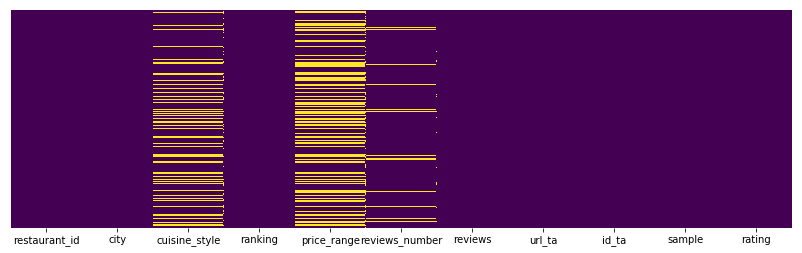

In [54]:
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

## Осмотр и обработка данных и генерация новых признаков 

In [55]:
def analyse_numeric(datafr, column):
    '''Визуализирует распределение числовой переменной.
       Принимает параметрами DataFrame и строковое название столбца
       Печатает различные статистические показатели и строит гистограмму.'''
    count = datafr[column].count()
    mean = datafr[column].mean()
    std = datafr[column].std()
    median = datafr[column].median()
    perc25 = datafr[column].quantile(0.25)
    perc75 = datafr[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = datafr[column].min()
    range_max = datafr[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = datafr[column].loc[(datafr[column] < perc25 - 1.5*IQR) | (datafr[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(datafr[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(outliers))

    datafr[column].loc[datafr[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                  .hist(bins = 30, range = range_, label = 'В границах выбросов')
    outliers.hist(bins = 30, range = range_, label = 'Выбросы')
    
    plt.legend()

### restaurant_id

In [56]:
df.restaurant_id.nunique()

13094

### city

In [57]:
df_tmp = df.city.value_counts()
df_tmp

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

Добавим столбец rests - количества ресторанов в городе

In [58]:
df['rests'] = df['city'].apply(lambda x: df_tmp[x])

Поработаем с популяциями городов. Добавим столбец population двумя разными способми: из внешнего датасета worldcities.csv с https://kaggle.com и из Википедии, https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits и проверим, какой способ лучше.

Способ 1

In [59]:
# cities = pd.read_csv(DATA_DIR+'/worldcities.csv')
# cities.head()

In [60]:
# def get_population(str_city):
#     '''Возвращает популяцию города str_city'''
#     if str_city.lower() == 'oporto': # Такого названия нет в датасете cities
#         str_city = 'porto' # Зато есть такое
#     return cities[cities.city_ascii.str.lower() == str_city.lower()]['population'].max()

In [61]:
# df['population'] = df.city.apply(lambda x: get_population(x))

Способ 2

In [62]:
population_dict = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}

In [63]:
df['population'] = df['city'].map(population_dict)

"Пронормируем" столбец population (получим значения в тысячах жителей)

In [64]:
df['population'] = df['population'] / 1000

Добавим столбец rest_density плотности ресторанов в городе

In [65]:
df['rest_density'] = df.rests / df.population

Добавим признак capital - является ли город столицей

In [66]:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
            'Bratislava', 'Vienna', 'Rome', 'Madrid',
            'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
            'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
            'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']
# Далее код закомментирован, так как признак ухудшает MAE
# df['capital'] = df['city'].apply(lambda x: x in capitals).astype('uint8')

Добавим признак country

In [67]:
countries_dict = {'Amsterdam': 'Netherlands',
             'Athens': 'Greece',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Bratislava': 'Slovakia',
             'Brussels': 'Belgium',
             'Budapest': 'Hungary',
             'Copenhagen': 'Denmark',
             'Dublin': 'Ireland',
             'Edinburgh': 'UK',
             'Geneva': 'Switzerland',
             'Hamburg': 'Germany',
             'Helsinki': 'Finland',
             'Krakow': 'Poland',
             'Lisbon': 'Portugal',
             'Ljubljana': 'Slovenia',
             'London': 'UK',
             'Luxembourg': 'Luxembourg',
             'Lyon': 'France',
             'Madrid': 'Spain',
             'Milan': 'Italy',
             'Munich': 'Germany',
             'Oporto': 'Portugal',
             'Oslo': 'Norway',
             'Paris': 'France',
             'Prague': 'Czechia',
             'Rome': 'Italy',
             'Stockholm': 'Sweden',
             'Vienna': 'Austria',
             'Warsaw': 'Poland',
             'Zurich': 'Switzerland'}

df['country'] = df['city'].map(countries_dict)

Добавим dummies по странам

In [68]:
df = pd.get_dummies(df, columns=['country']) # , dummy_na=True # в странах пропусков нет
df.head(3)

,restaurant_id,city,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,rating,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,6108,2140.526,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,475,648.042,0.732977,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,745,524.930,1.419237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Добавим dummies по городам

In [69]:
# Альтернативный вариант кода: df = pd.concat([df, pd.get_dummies(df.city)], axis=1) - Не добавляет префикс city
df = pd.get_dummies(df, columns=['city',]) # , dummy_na=True # в городах пропусков нет
df.head(3)

,restaurant_id,cuisine_style,ranking,price_range,reviews_number,reviews,url_ta,id_ta,sample,rating,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,6108,2140.526,2.853504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,475,648.042,0.732977,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,745,524.930,1.419237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### cuisine_style

In [71]:
df.cuisine_style.value_counts()

['Italian']                                                                                                    1332
['French']                                                                                                     1019
['Spanish']                                                                                                     860
['French', 'European']                                                                                          503
['Cafe']                                                                                                        500
                                                                                                               ... 
['French', 'Belgian', 'European', 'Gluten Free Options']                                                          1
['Italian', 'French', 'Mediterranean', 'Greek', 'Grill']                                                          1
['American', 'Bar', 'Central American', 'Contemporary']                 

In [72]:
df['cuisine_style_isna'] = pd.isna(df.cuisine_style).astype('uint8')

In [73]:
df.cuisine_style.fillna('1', inplace=True)

In [74]:
df['cuisine'] = df.cuisine_style.str[1:-1].str.split(', ')

In [98]:
df['cuisine'].sample(5)

37411    ['Dutch', 'Seafood', 'European', 'Gluten Free ...
36745                      ['Cafe', 'Vegetarian Friendly']
14758                                                   []
43064    ['Japanese', 'Asian', 'Soups', 'Vegetarian Fri...
19597                               ['French', 'European']
Name: cuisine, dtype: object

In [99]:
len(df.explode('cuisine')['cuisine'].value_counts())

126

Создадим новый признак cuisines_number - количество кухонь, представленных рестораном

In [100]:
df['cuisines_number'] = df['cuisine'].apply( lambda x: 1.0 if len(x)==0 else float(len(x)))

### ranking

Количество: 50000, Среднее: 3664.428, Стандартное отклонение: 3700.092.
Минимум: 1.0, 25-й перцентиль: 972.0, Медиана: 2278.0, 75-й перцентиль: 5241.0, Максимум: 16444.0, IQR: 4269.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5431.5, 11644.5]. Количество выбросов:  3075


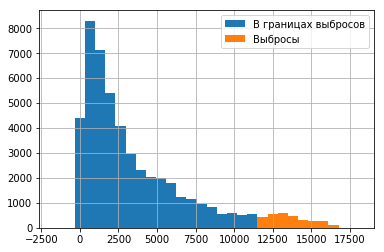

In [101]:
analyse_numeric(df, 'ranking')

Создадим новый признак путем нормирования ranking к количеству ресторанов в городе

In [103]:
df['ranking_norm_rests'] = df.ranking / df.rests

### rating

Количество: 50000, Среднее: 3.194, Стандартное отклонение: 1.705.
Минимум: 0.0, 25-й перцентиль: 3.0, Медиана: 4.0, 75-й перцентиль: 4.5, Максимум: 5.0, IQR: 1.5.
Количество пропусков в столбце:  0
Границы выбросов: [0.75, 6.75]. Количество выбросов:  10000


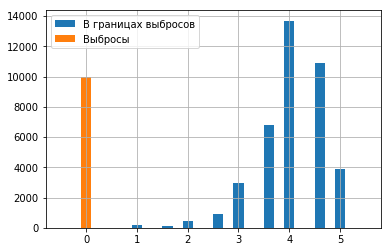

In [104]:
analyse_numeric(df, 'rating')

### price_range

In [105]:
df.price_range.value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [106]:
df['price_range_isna'] = pd.isna(df.price_range).astype('uint8')

In [107]:
# Нужно заполнить пропуски.
# Либо так:
#df['price_range_label'] = df.price_range.apply(lambda x: 1.0 if x=='$' else 2.5 if x=='$$ - $$$' else 4.0 if x=='$$$$' else np.nan)
# и заполним медианой по городам
#df.price_range_label = df.apply(lambda row: df[df.city==row.city].price_range_label.median() if pd.isna(row.price_range_label) \
#                                                                                     else row.price_range_label, axis=1)

# Либо так:
df['price_range_label'] = df.price_range.apply(lambda x: 2.5 if pd.isnull(x) else 1.0 if x=='$' else 2.5 if x=='$$ - $$$' else 4.0)

### reviews_number

Количество: 46800, Среднее: 124.471, Стандартное отклонение: 294.114.
Минимум: 2.0, 25-й перцентиль: 9.0, Медиана: 33.0, 75-й перцентиль: 115.0, Максимум: 9660.0, IQR: 106.0.
Количество пропусков в столбце:  3200
Границы выбросов: [-150.0, 274.0]. Количество выбросов:  5428


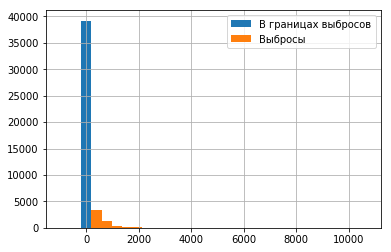

In [108]:
analyse_numeric(df, 'reviews_number')

In [109]:
df['reviews_number_isna'] = pd.isna(df.reviews_number).astype('uint8')

In [ ]:
# Заполним пропуски значением 0

In [110]:
df.reviews_number.fillna(0, inplace=True)

In [111]:
# Нормируем количество отзывов к населению города
df['reviews_number_norm'] = df.reviews_number / df.population

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [ ]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [ ]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

In [ ]:
df_preproc.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
